<a href="https://colab.research.google.com/github/Aditi840/Guvi-Tasks/blob/main/D43_Task5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df1 = pd.read_csv('/content/takehome_users.csv', encoding='ISO-8859-1')
df2 = pd.read_csv('/content/takehome_user_engagement.csv')

In [3]:
print(df1.duplicated().sum())
print(df2.duplicated().sum())
print(df1.isnull().sum())
print(df2.isnull().sum())
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df1.dropna(inplace=True)
df2.dropna(inplace=True)
print(df1.columns)
print(df2.columns)

0
0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64
time_stamp    0
user_id       0
visited       0
dtype: int64
Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')
Index(['time_stamp', 'user_id', 'visited'], dtype='object')


In [4]:
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])
grouped = df2.groupby(['user_id', pd.Grouper(key='time_stamp', freq='D')])['visited'].count()
grouped = grouped.reset_index()
print(grouped.head())


   user_id time_stamp  visited
0        1 2014-04-22        1
1        2 2013-11-15        1
2        2 2013-11-29        1
3        2 2013-12-09        1
4        2 2013-12-25        1


In [5]:
print(df1.columns)
print(df2.columns)

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')
Index(['time_stamp', 'user_id', 'visited'], dtype='object')


In [6]:
df2.set_index('time_stamp', inplace=True)
grouped = df2.groupby('user_id').resample('D').sum().fillna(0)
rolling_window = grouped.rolling(window=7, min_periods=1)['visited'].apply(lambda x: x.nunique(), raw=False)
rolling_window = rolling_window.reset_index()
print(rolling_window.head())

   user_id time_stamp  visited
0        1 2014-04-22      1.0
1        2 2013-11-15      1.0
2        2 2013-11-16      2.0
3        2 2013-11-17      2.0
4        2 2013-11-18      2.0


In [7]:
rolling_window['rolling_sum'] = rolling_window.groupby('user_id')['visited'].rolling(window=7, min_periods=1).sum().values
adopted_users = rolling_window[rolling_window['rolling_sum'] >= 3]
adopted_user_ids = adopted_users['user_id'].unique()
df1['adopted_user'] = df1['object_id'].isin(adopted_user_ids).astype(int)
print(df1.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [8]:
merged_df = df1.merge(adopted_users[['user_id', 'rolling_sum']], how='left', left_on='object_id', right_on='user_id')
merged_df.drop('user_id', axis=1, inplace=True)
merged_df['adopted_user'] = merged_df['rolling_sum'].notnull().astype(int)
print(merged_df)

        object_id        creation_time            name  \
0               1  2014-04-22 03:53:30  Clausen August   
1               2  2013-11-15 03:45:04   Poole Matthew   
2               2  2013-11-15 03:45:04   Poole Matthew   
3               2  2013-11-15 03:45:04   Poole Matthew   
4               2  2013-11-15 03:45:04   Poole Matthew   
...           ...                  ...             ...   
293401      11981  2013-03-05 01:53:48       Fry Tyler   
293402      11982  2013-12-06 14:39:15   Barajas Maria   
293403      11990  2013-07-05 21:00:48       Juhl Aase   
293404      11996  2013-09-06 06:14:15    Meier Sophia   
293405      11998  2014-04-27 12:45:16     Haynes Jake   

                           email creation_source  last_session_creation_time  \
0       AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1         MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2         MatthewPoole@gustr.com      ORG_INVITE               

In [9]:
merged_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,rolling_sum
count,293406.000000,2.934060e+05,293406.000000,293406.000000,293406.000000,293406.000000,293406.000000,290109.000000
mean,5970.953661,1.397437e+09,0.261712,0.159894,159.824792,5974.511585,0.988763,11.954365
std,3473.028141,1.100900e+07,0.439568,0.366509,119.636455,3290.952751,0.105408,2.749222
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,3.000000
25%,3113.000000,1.400784e+09,0.000000,0.000000,58.000000,3227.000000,1.000000,10.000000
50%,5830.000000,1.401466e+09,0.000000,0.000000,136.000000,5981.000000,1.000000,14.000000
75%,9089.000000,1.401844e+09,1.000000,0.000000,255.000000,8623.000000,1.000000,14.000000
max,11998.000000,1.402067e+09,1.000000,1.000000,415.000000,11999.000000,1.000000,14.000000


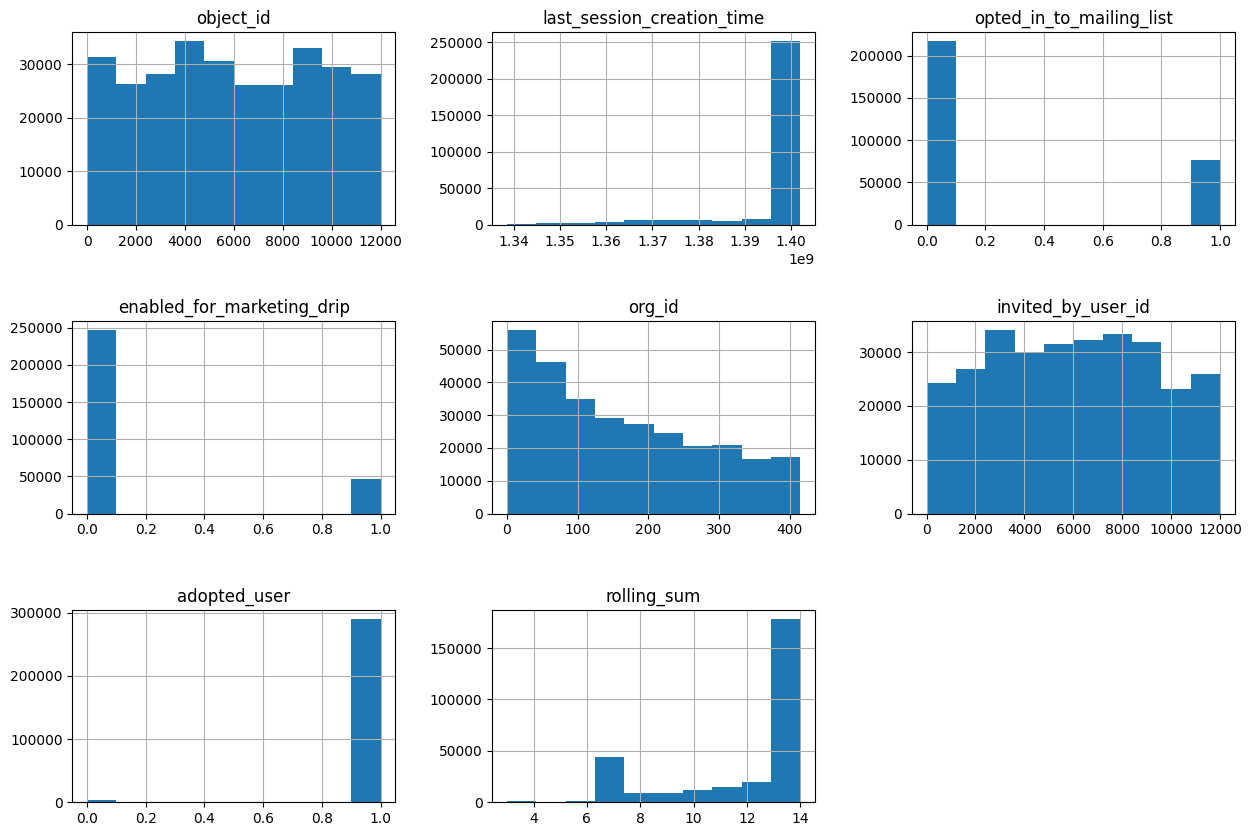

In [10]:
merged_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [11]:
pd.crosstab(merged_df['creation_source'], merged_df['adopted_user'])
pd.crosstab(merged_df['opted_in_to_mailing_list'], merged_df['adopted_user'])
pd.crosstab(merged_df['enabled_for_marketing_drip'], merged_df['adopted_user'])

adopted_user,0,1
enabled_for_marketing_drip,,
0,2794,243698
1,503,46411


<Axes: xlabel='enabled_for_marketing_drip', ylabel='count'>

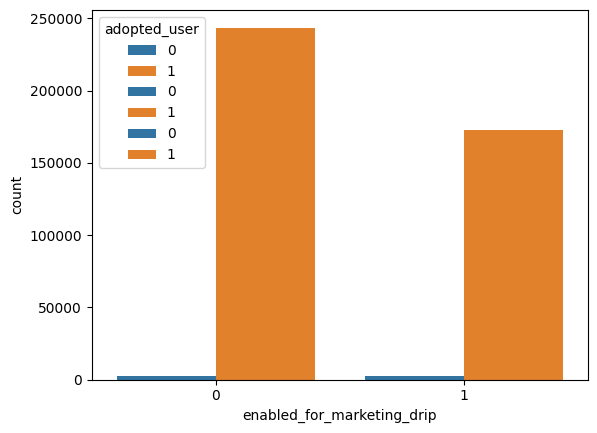

In [12]:
sns.countplot(x='creation_source', hue='adopted_user', data=merged_df)
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=merged_df)
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=merged_df)

<ipython-input-13-8e21373d8c30>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')


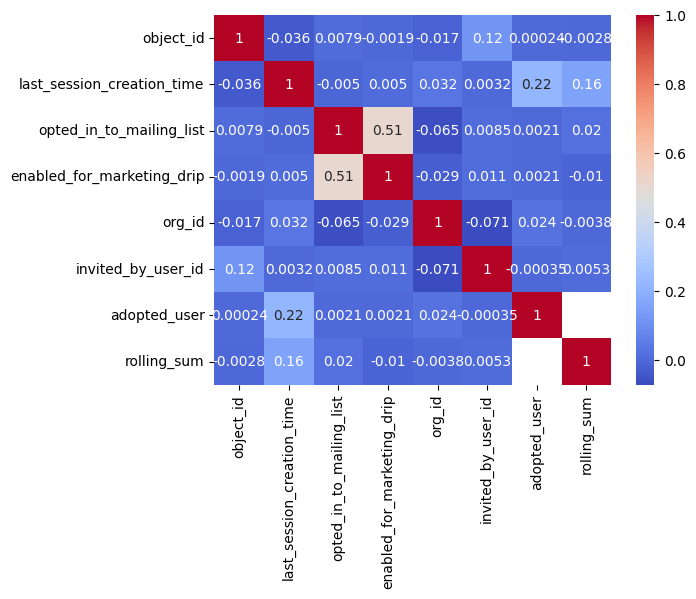

In [13]:
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [14]:
ct = pd.crosstab(merged_df['opted_in_to_mailing_list'], merged_df['adopted_user'])
chi2, p, dof, expected = stats.chi2_contingency(ct)
print('Chi-squared test statistic:', chi2)
print('p-value:', p)

Chi-squared test statistic: 1.277416291909196
p-value: 0.2583799853510176


In [15]:
crosstab = pd.crosstab(merged_df['creation_source'], merged_df['adopted_user'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print("Chi-squared test results for 'creation_source' and future adoption:")
print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

Chi-squared test results for 'creation_source' and future adoption:
Chi-squared statistic: 127.8433
P-value: 0.0000


In [16]:
crosstab = pd.crosstab(merged_df['enabled_for_marketing_drip'], merged_df['adopted_user'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print("Chi-squared test results for 'enabled_for_marketing_drip' and future adoption:")
print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

Chi-squared test results for 'enabled_for_marketing_drip' and future adoption:
Chi-squared statistic: 1.2797
P-value: 0.2580


In [17]:
print(df1.columns)
print(df2.columns)

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user'],
      dtype='object')
Index(['user_id', 'visited'], dtype='object')


In [18]:
print(merged_df.columns)

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'rolling_sum'],
      dtype='object')


In [19]:
print(merged_df)

        object_id        creation_time            name  \
0               1  2014-04-22 03:53:30  Clausen August   
1               2  2013-11-15 03:45:04   Poole Matthew   
2               2  2013-11-15 03:45:04   Poole Matthew   
3               2  2013-11-15 03:45:04   Poole Matthew   
4               2  2013-11-15 03:45:04   Poole Matthew   
...           ...                  ...             ...   
293401      11981  2013-03-05 01:53:48       Fry Tyler   
293402      11982  2013-12-06 14:39:15   Barajas Maria   
293403      11990  2013-07-05 21:00:48       Juhl Aase   
293404      11996  2013-09-06 06:14:15    Meier Sophia   
293405      11998  2014-04-27 12:45:16     Haynes Jake   

                           email creation_source  last_session_creation_time  \
0       AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1         MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2         MatthewPoole@gustr.com      ORG_INVITE               

In [21]:
merged_df['creation_time'] = pd.to_datetime(merged_df['creation_time'])

In [23]:
label_encoder = LabelEncoder()
merged_df['creation_source'] = label_encoder.fit_transform(merged_df['creation_source'])

In [31]:
print(merged_df.columns)

Index(['object_id', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'rolling_sum'],
      dtype='object')


In [35]:
merged_df['rolling_sum'] = merged_df['rolling_sum'].fillna(0)

In [37]:
print(merged_df)

        object_id  creation_source  last_session_creation_time  \
0               1                0                1.398139e+09   
1               2                1                1.396238e+09   
2               2                1                1.396238e+09   
3               2                1                1.396238e+09   
4               2                1                1.396238e+09   
...           ...              ...                         ...   
293401      11981                0                1.364868e+09   
293402      11982                1                1.386341e+09   
293403      11990                1                1.373144e+09   
293404      11996                1                1.378448e+09   
293405      11998                0                1.398603e+09   

        opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                              1                           0      11   
1                              0                           0   

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
X = merged_df.drop('adopted_user', axis=1)
y = merged_df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Get feature importances
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature rankings
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
scores = cross_val_score(rfc, X, y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



[[  994     0]
 [    0 87028]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       994
           1       1.00      1.00      1.00     87028

    accuracy                           1.00     88022
   macro avg       1.00      1.00      1.00     88022
weighted avg       1.00      1.00      1.00     88022

Feature ranking:
1. feature 7 (0.939707)
2. feature 2 (0.037607)
3. feature 0 (0.007340)
4. feature 5 (0.006482)
5. feature 6 (0.006367)
6. feature 3 (0.001004)
7. feature 1 (0.000823)
8. feature 4 (0.000670)
Accuracy: 1.00 (+/- 0.00)


In [46]:

# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[    0   994]
 [    0 87028]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       994
           1       0.99      1.00      0.99     87028

    accuracy                           0.99     88022
   macro avg       0.49      0.50      0.50     88022
weighted avg       0.98      0.99      0.98     88022



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
